In [1]:
# load data libraries
import numpy as np
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split


# data understanding libraries
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter


# data preparation
import re
from nltk.stem import PorterStemmer


# ADS Creation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB

# Evaluation and Model Selection
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

In [2]:
#unzip and load the training files
train = pd.read_csv('train.tsv.zip',delimiter='\t')

#output the first 10 rows
train.sample(10)

,PhraseId,SentenceId,Phrase,Sentiment
4344,4345,165,turn and,2
91318,91319,4750,3-year-olds,2
61136,61137,3089,a story and,2
58875,58876,2970,"A clumsily manufactured exploitation flick , a...",1
94144,94145,4913,made herself,2
7976,7977,326,but an episode,2
58606,58607,2953,For those in search of something different,2
91698,91699,4771,"direction , story and pace",2
31596,31597,1480,Weighty and ponderous,2
84203,84204,4351,", I pledge allegiance to Cagney and Lacey .",3


In [3]:
#Split the data into the training and test set
train_data, test_data = train_test_split(train, test_size=0.4, random_state=1)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=1)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [4]:
#Let's check the sizes of each
print("Train set size is ",len(train_data))
print("Val set size is ",len(val_data))
print("Test set size is ",len(test_data))

Train set size is  93636
Val set size is  31212
Test set size is  31212


In [5]:
#Info of the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93636 entries, 0 to 93635
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    93636 non-null  int64 
 1   SentenceId  93636 non-null  int64 
 2   Phrase      93636 non-null  object
 3   Sentiment   93636 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.9+ MB


In [6]:
words = " ".join([row["Phrase"]for ind, row in train_data.iterrows()]).split()

In [7]:
#Split words of the phrase
train_data['Phrase'].str.split()

0                                                [Pauline]
1                                         [trying, to, go]
2                                      [a, week, to, live]
3                   [Essentially, a, collection, of, bits]
4        [The, director, ,, with, his, fake, backdrops,...
                               ...                        
93631                          [concerned, with, morality]
93632                           [into, the, editing, room]
93633                                   [pack, raw, dough]
93634                                [well-wrought, story]
93635    [as, the, main, character, suggests, ,, `, wha...
Name: Phrase, Length: 93636, dtype: object

In [8]:
#Number of different words
len(set(words))

18096

In [9]:
#Remove unwanted words and punctuations
stopwords = set(["RRB","LRB","CGI","zzzzzzzzz","'s"])

def ret_words(words):
    words = words.replace('-', ' ')
    words = words.replace(',', ' ')
    words = words.replace('--', ' ')
    words = words.replace('`', ' ')
    words = words.replace('``', ' ')
    words = words.replace('\/', ' ')
    words = words.replace(';', ' ')
    words = words.replace(':', ' ')
    words = words.replace('.', ' ')
    words = words.replace('*', ' ')
    words = words.replace("''", ' ')
    
    text = []
    for word in words.split():
        if word in stopwords: continue
        text.append(word)
    return ' '.join(text)

def preprocess(df,flag):
     # Convert list of ingredients to string
    df['Phrase_txt'] = df["Phrase"].apply(ret_words)
    return df

In [10]:
train_preprocessed = preprocess(train_data,0)
val_preprocessed = preprocess(val_data,1)
test_preprocessed = preprocess(test_data,1)

In [11]:
#Review after removing the words and punctuations
train_preprocessed.sample(10)

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_txt
73661,41287,1981,says far less about the horrifying historical ...,1,says far less about the horrifying historical ...
23238,107323,5671,very effective,4,very effective
35056,1648,61,is so pat it makes your teeth hurt .,1,is so pat it makes your teeth hurt
22929,139194,7545,is disappointingly,0,is disappointingly
38713,13815,595,charming and evoking,4,charming and evoking
84912,88771,4612,spiked by jolts of pop music,3,spiked by jolts of pop music
91209,155212,8497,Reno does what he can in a thankless situation...,3,Reno does what he can in a thankless situation...
10712,72298,3695,guess a space station in the year 2455 can be ...,0,guess a space station in the year 2455 can be ...
14368,105460,5569,Colgate,2,Colgate
17557,56001,2801,The high-concept scenario soon proves preposte...,1,The high concept scenario soon proves preposte...


In [12]:
len(set(pd.Series(' '.join([row["Phrase_txt"] for ind,row in train_preprocessed.iterrows()]).split(' '))))

16895

In [13]:
#Split the data into the respective X and Y values
id_train, X_train, y_train =  train_preprocessed['PhraseId'], train_preprocessed['Phrase_txt'], train_preprocessed['Sentiment']
id_val, X_val, y_val = val_preprocessed['PhraseId'], val_preprocessed['Phrase_txt'], val_preprocessed['Sentiment']
id_test, X_test, y_test =test_preprocessed['PhraseId'], test_preprocessed['Phrase_txt'], test_preprocessed['Sentiment']

In [14]:
#We will now try different models to see which gives best results

#Logistic Regression model
LR_clf_counts = Pipeline([('vect', CountVectorizer()),('clf', LogisticRegression(random_state=0, max_iter=2000))])
LR_clf_counts.fit(X_train, y_train)
LR_cnt_pred_tr = LR_clf_counts.predict(X_train)

print(accuracy_score(y_train, LR_cnt_pred_tr))
print(precision_score(y_train, LR_cnt_pred_tr, average='weighted'))

0.7304348754752445
0.7281238636213457


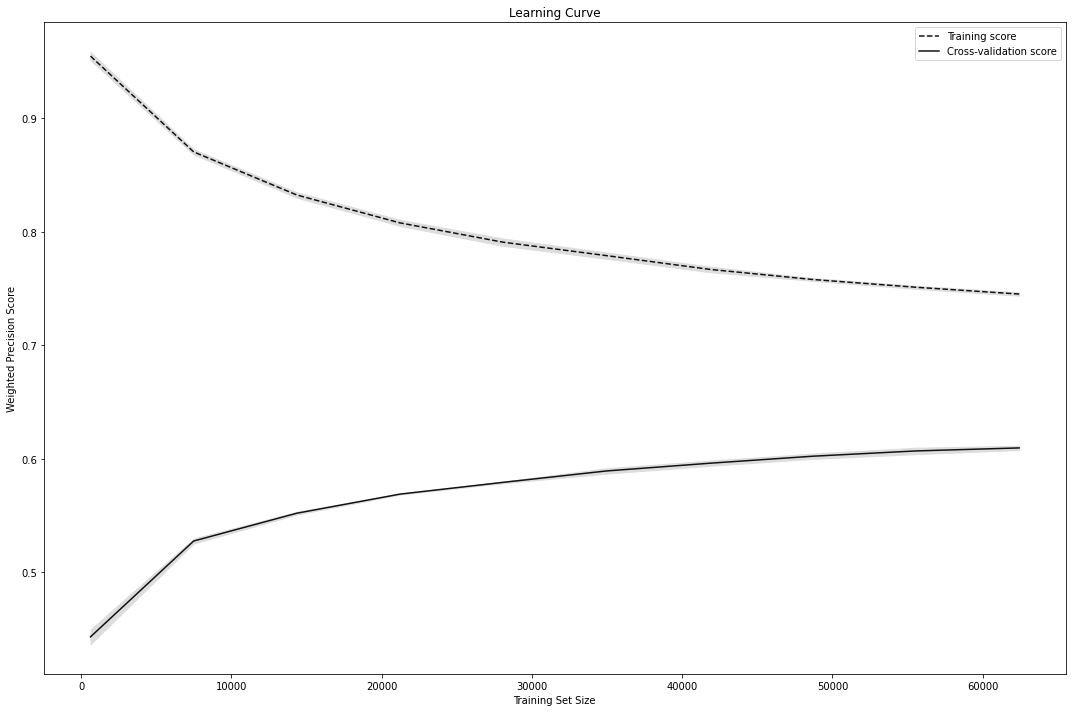

In [15]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LR_clf_counts,X_train,y_train,cv=3,scoring='precision_weighted',n_jobs=-1,train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [16]:
#Support Vector Machine - LinearSVC
SVM_clf_counts = Pipeline([('vect', CountVectorizer()),('clf', LinearSVC(max_iter=3000))])
SVM_clf_counts.fit(X_train, y_train)
SVM_cnt_pred_tr = SVM_clf_counts.predict(X_train)

print(accuracy_score(y_train, SVM_cnt_pred_tr))
print(precision_score(y_train, SVM_cnt_pred_tr, average='weighted'))

0.7492097056687599
0.7459823196224461


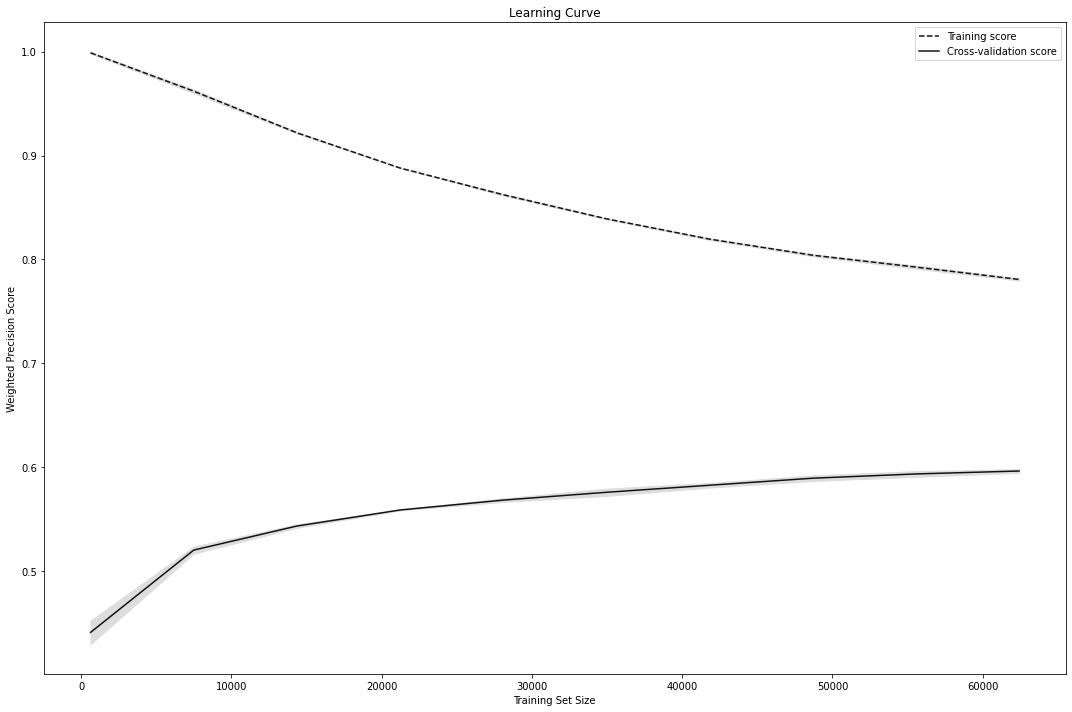

In [17]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVM_clf_counts,X_train,y_train,cv=3,scoring='precision_weighted',n_jobs=-1,train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [18]:
#Multinomial Naive Bayes
NB_clf_counts = Pipeline([('vect', CountVectorizer()),('clf', MultinomialNB())])
NB_clf_counts.fit(X_train, y_train)
NB_cnt_pred_tr = NB_clf_counts.predict(X_train)

print(accuracy_score(y_train, NB_cnt_pred_tr))
print(precision_score(y_train, NB_cnt_pred_tr, average='weighted'))

0.6806249733008672
0.6718214289545724


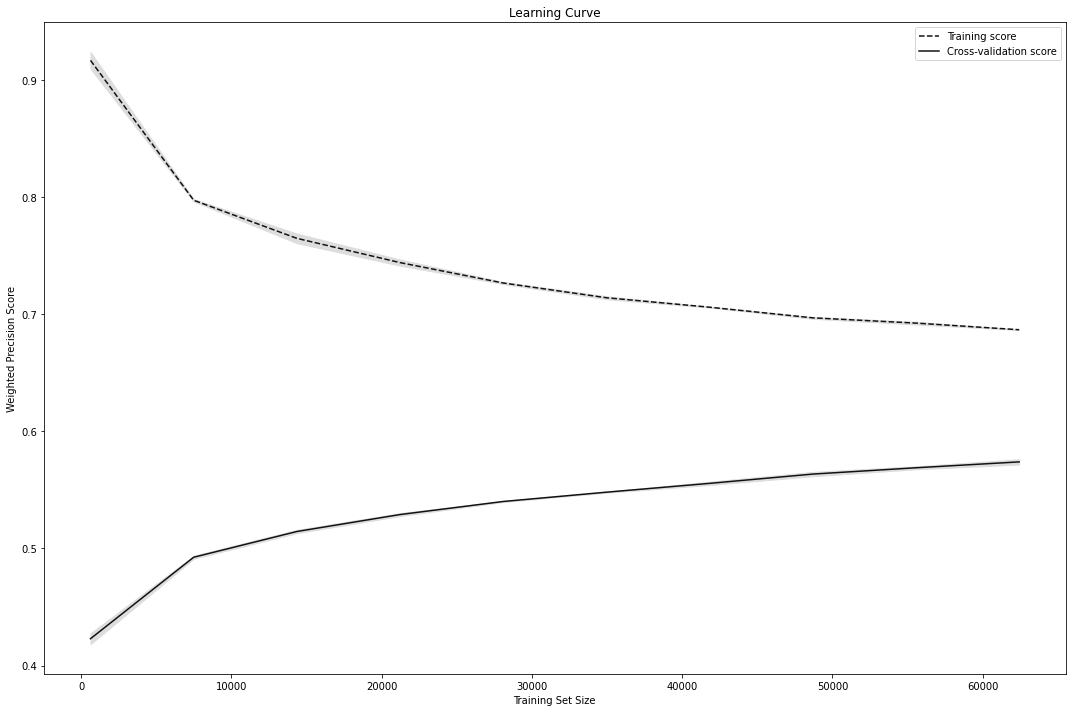

In [19]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(NB_clf_counts, X_train, y_train,cv=3,scoring='precision_weighted',n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [20]:
#Logistic Regressor but with different vectorizer
LR_clf_tfidf = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.25, norm='l2', encoding='latin-1',ngram_range=(1, 2), stop_words='english')),('clf', LogisticRegression(random_state=0, max_iter=2000))])
LR_clf_tfidf.fit(X_train, y_train)
LR_tfidf_pred_tr = LR_clf_tfidf.predict(X_train)

print(accuracy_score(y_train, LR_tfidf_pred_tr))
print(precision_score(y_train, LR_tfidf_pred_tr, average='weighted'))

0.7083066342005212
0.7102583566141313


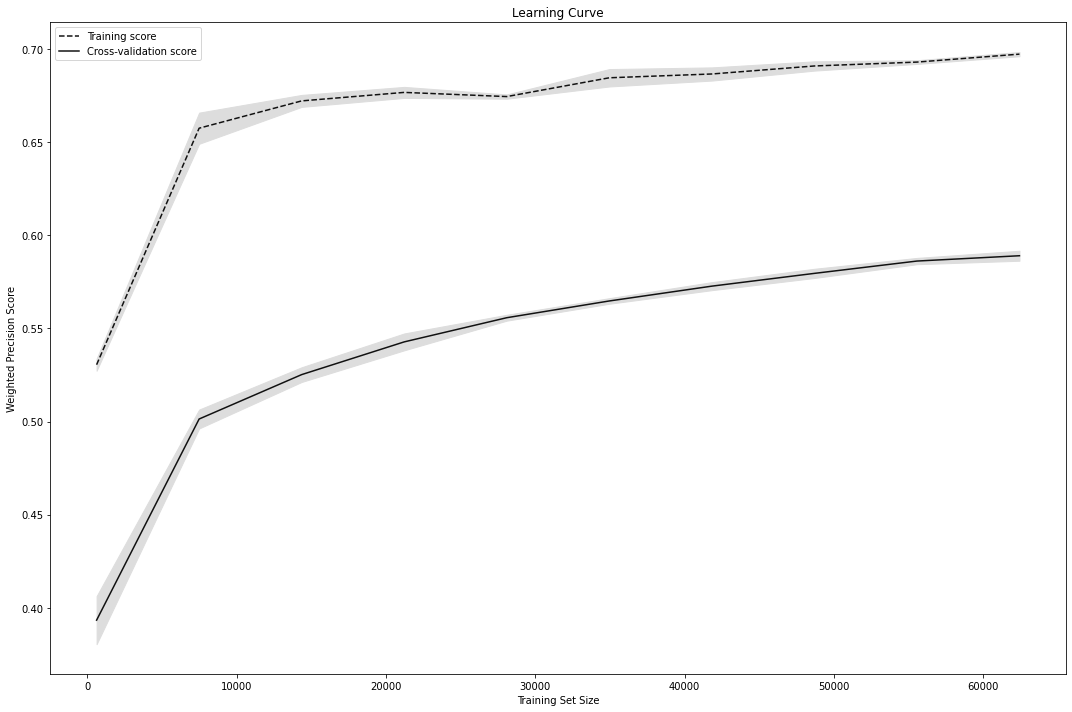

In [21]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LR_clf_tfidf, X_train, y_train,cv=3,scoring='precision_weighted',n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [22]:
#Support Vector Machine - Linear SVC but with different vectorizer
SVM_clf_tfidf = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.25, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),('clf', LinearSVC( max_iter=2000))])
SVM_clf_tfidf.fit(X_train, y_train)
SVM_tfidf_pred_tr = SVM_clf_tfidf.predict(X_train)

print(accuracy_score(y_train, SVM_tfidf_pred_tr))
print(precision_score(y_train, SVM_tfidf_pred_tr, average='weighted'))

0.7713806655559827
0.7676422371873227


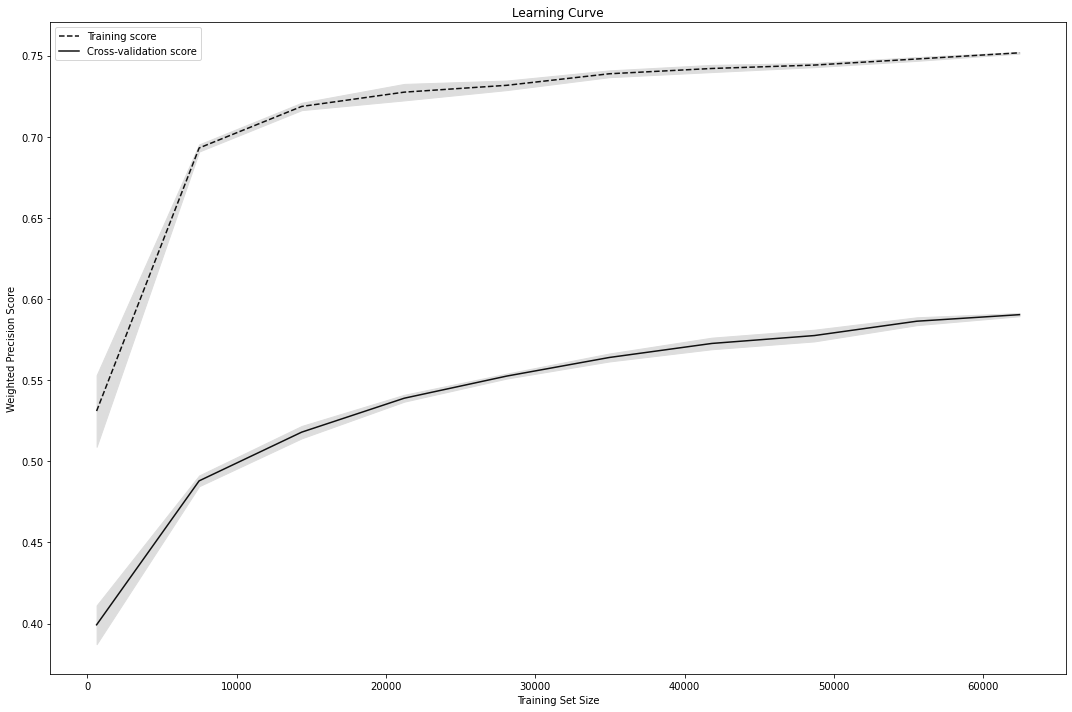

In [23]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVM_clf_tfidf, X_train, y_train,cv=3,scoring='precision_weighted',n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [24]:
#Multinomial but with different vectorizer
NB_clf_tfidf = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.25, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),('clf', MultinomialNB())])
NB_clf_tfidf.fit(X_train, y_train)
NB_tfidf_pred_tr = NB_clf_tfidf.predict(X_train)

print(accuracy_score(y_train, NB_tfidf_pred_tr))
print(precision_score(y_train, NB_tfidf_pred_tr, average='weighted'))

0.6683326925541458
0.6832233642076752


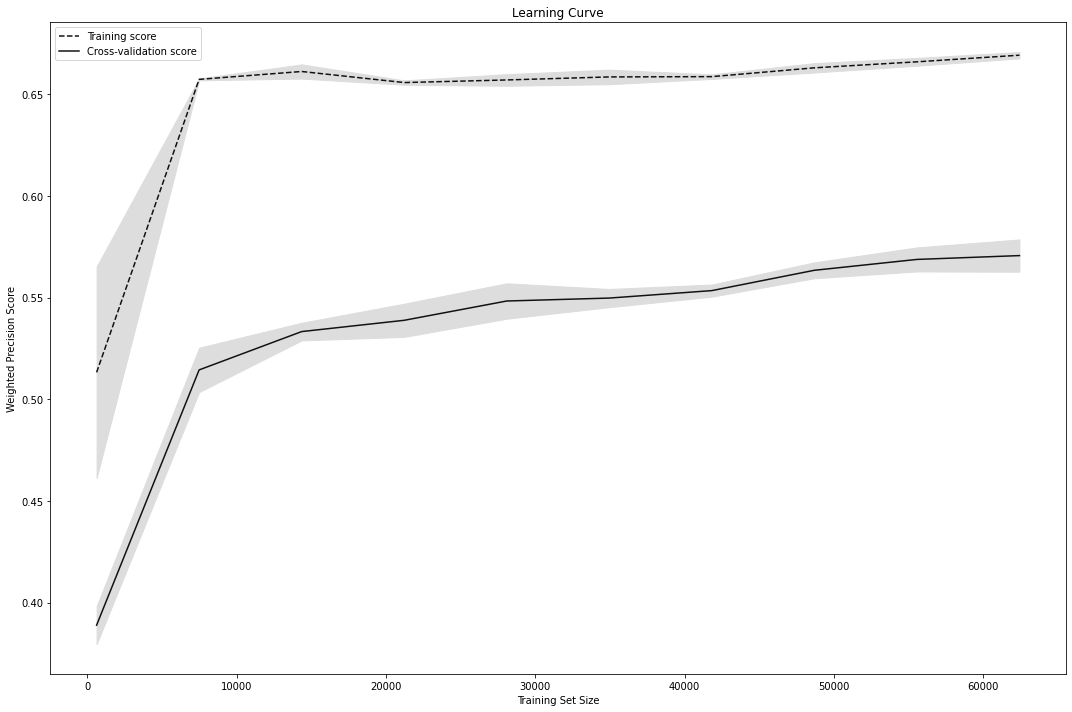

In [25]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(NB_clf_tfidf, X_train, y_train,cv=3,scoring='precision_weighted',n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [26]:
vect=  CountVectorizer()
X_train_cnt = vect.fit_transform(X_train)

In [27]:
def LR_param_selection(X, y, nfolds):
    Cs = [0.01, 0.1, 1, 10]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(LogisticRegression(random_state=0,max_iter=2000), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [28]:
LR_param_selection( X_train_cnt,y_train,2)

{'C': 1}

In [29]:
#Logistic Rregression but with best parameters
LR_clf_counts = Pipeline([('vect', CountVectorizer()),('clf', LogisticRegression(C=1,random_state=0, max_iter=2000)),])
LR_clf_counts.fit(X_train, y_train)
LR_cnt_pred_tr = LR_clf_counts.predict(X_train)
LR_cnt_pred_val = LR_clf_counts.predict(X_val)

print("accuracy on training: ",accuracy_score(y_train, LR_cnt_pred_tr))
print("precision on training: ",precision_score(y_train, LR_cnt_pred_tr, average='micro'))
print("precision on validation: ",precision_score(y_val, LR_cnt_pred_val, average='micro'))

accuracy on training:  0.7304348754752445
precision on training:  0.7304348754752445
precision on validation:  0.646962706651288


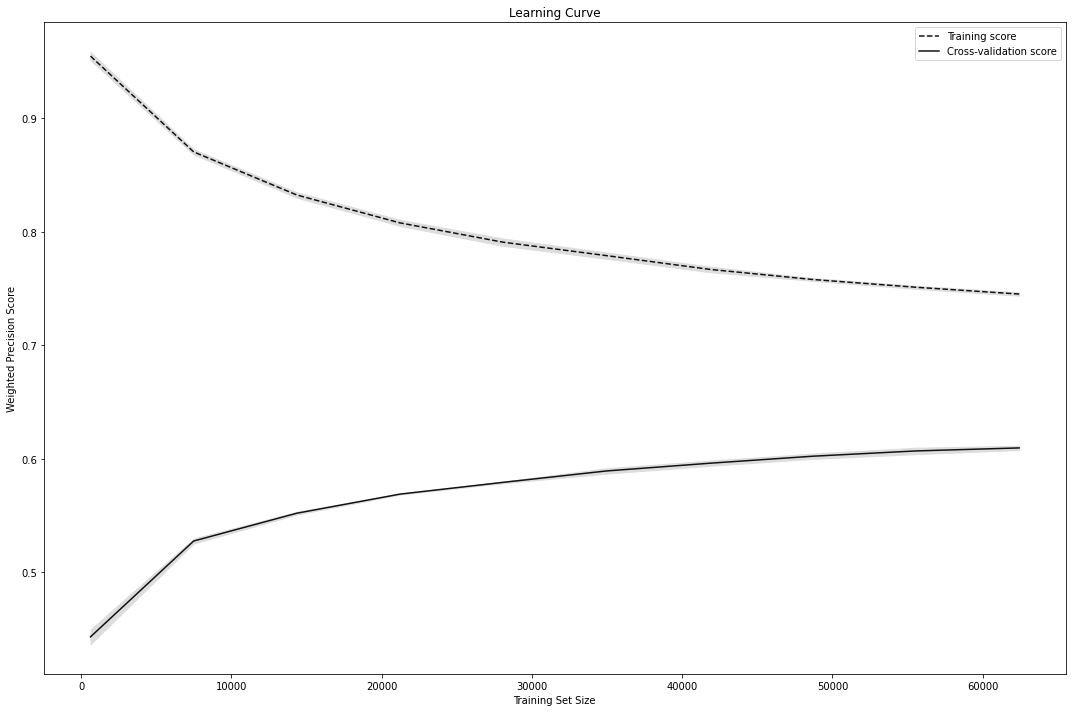

In [30]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LR_clf_counts, X_train, y_train,cv=3,scoring='precision_weighted',n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [31]:
#Using the above models and graph, we choose the best one and recreate it

archive_train = zipfile.ZipFile('train.tsv.zip')
archive_test = zipfile.ZipFile('test.tsv.zip')
final_train = pd.read_csv('train.tsv.zip',delimiter='\t')
final_test = pd.read_csv('test.tsv.zip',delimiter='\t')

In [32]:
ftrain_preprocessed = preprocess(final_train,0)
ftest_preprocessed = preprocess(final_test,1)

In [33]:
id_train, X_train, y_train =  ftrain_preprocessed['PhraseId'], ftrain_preprocessed['Phrase_txt'], ftrain_preprocessed['Sentiment']
id_test, X_test = ftest_preprocessed['PhraseId'], ftest_preprocessed['Phrase_txt']

In [34]:
LR_clf = Pipeline([('vect', CountVectorizer()),('clf', LogisticRegression(C=1,random_state=0, max_iter=2000))])
LR_clf.fit(X_train, y_train)
pred_tst = LR_clf_counts.predict(X_test)

In [35]:
#Save our output to a csv file
output=pd.DataFrame({'PhraseId' : id_test , 'Sentiment' : pred_tst})
output.to_csv('Sentiment_preds_LR.csv' , index = False)